In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
tick_data = pd.read_csv("/Users/katyaluchette/Downloads/weekly_lyme_disease_cases.csv")
tick_data.head()

,Year,Cases,MMWR Week
0,2010,127,1
1,2010,157,2
2,2010,99,3
3,2010,88,4
4,2010,134,5


In [4]:
tick_data['Date'] = pd.to_datetime(tick_data['Year'].astype(str) + tick_data['MMWR Week'].astype(str) + '0', format='%Y%U%w')
tick_data = tick_data.drop(columns = ["Year"])
lyme_disease = tick_data.drop(columns = ["MMWR Week"])
lyme_disease.head(10)

,Cases,Date
0,127,2010-01-03
1,157,2010-01-10
2,99,2010-01-17
3,88,2010-01-24
4,134,2010-01-31
5,96,2010-02-07
6,114,2010-02-14
7,88,2010-02-21
8,213,2010-02-28
9,128,2010-03-07


In [5]:
lyme_disease_rate = lyme_disease[['Date', 'Cases']]
lyme_disease_rate.set_index('Date', inplace = True)
lyme_diease_rate = lyme_disease_rate.dropna()
lyme_disease_rate.head()

,Cases
Date,
2010-01-03,127
2010-01-10,157
2010-01-17,99
2010-01-24,88
2010-01-31,134


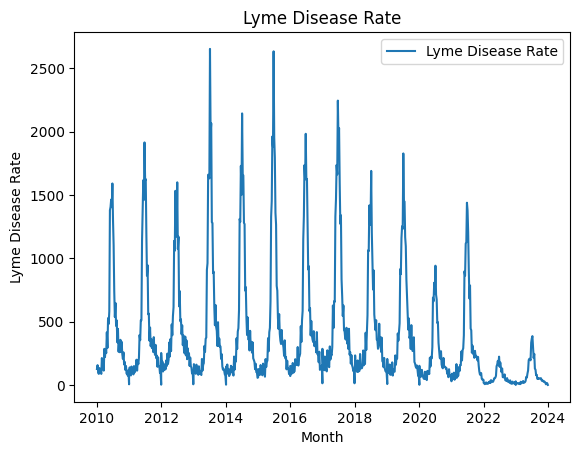

In [6]:
plt.plot(lyme_disease_rate['Cases'], label='Lyme Disease Rate')
plt.xlabel('Month')
plt.ylabel('Lyme Disease Rate')
plt.legend()
plt.title('Lyme Disease Rate')
plt.show();

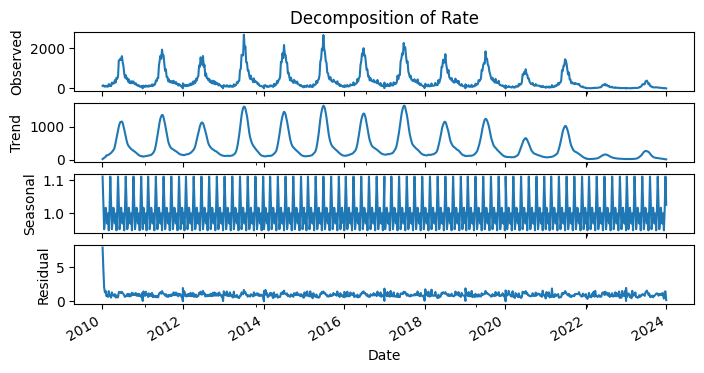

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp1 = seasonal_decompose(lyme_disease_rate['Cases'], period=10, model='multiplicative', extrapolate_trend='freq')

fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(8,4))
ax[0].set_title('Decomposition of Rate')
decomp1.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')

decomp1.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')

decomp1.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')

decomp1.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')

plt.show();

In [8]:
for i in range(1, 11):
    lyme_disease_rate[f'Lag {i}'] = lyme_diease_rate['Cases'].shift(i)

lyme_disease_rate = lyme_disease_rate.dropna()
lyme_disease_rate.head()

,Cases,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,Lag 10
Date,,,,,,,,,,,
2010-03-14,182,128.0,213.0,88.0,114.0,96.0,134.0,88.0,99.0,157.0,127.0
2010-03-21,114,182.0,128.0,213.0,88.0,114.0,96.0,134.0,88.0,99.0,157.0
2010-03-28,286,114.0,182.0,128.0,213.0,88.0,114.0,96.0,134.0,88.0,99.0
2010-04-04,221,286.0,114.0,182.0,128.0,213.0,88.0,114.0,96.0,134.0,88.0
2010-04-11,284,221.0,286.0,114.0,182.0,128.0,213.0,88.0,114.0,96.0,134.0


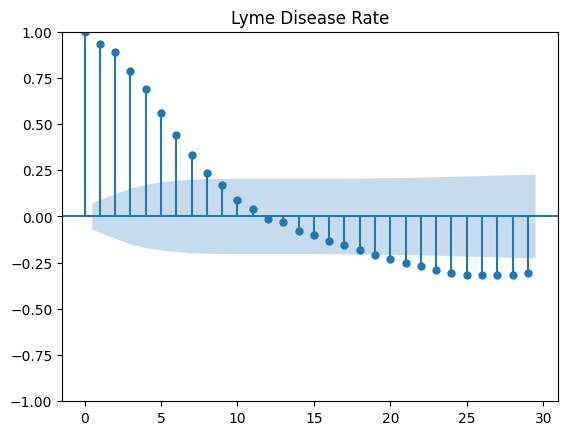

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

series = lyme_disease_rate['Cases']
plot_acf(series, title = 'Lyme Disease Rate')
plt.show();

In [13]:
train_size = int(.8 * len(lyme_disease_rate))
train_data = lyme_disease_rate[:train_size]
test_data = lyme_disease_rate[train_size:]

# put the y feature in arrays
y_train = np.array(train_data['Cases']).reshape(-1,1)
y_test = np.array(test_data['Cases']).reshape(-1,1)

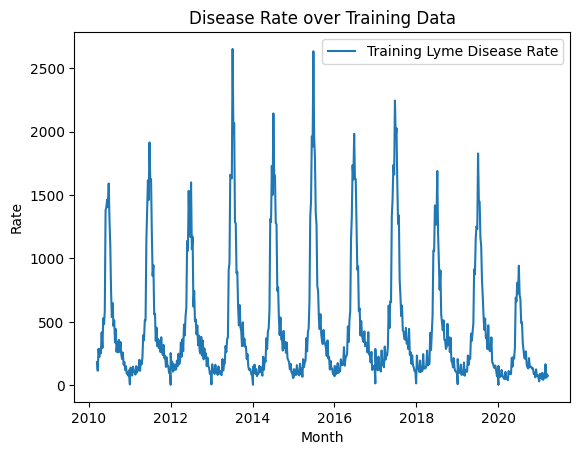

In [14]:
plt.plot(train_data['Cases'], label='Training Lyme Disease Rate')
plt.xlabel('Month')
plt.ylabel('Rate')
plt.legend()
plt.title('Disease Rate over Training Data')
plt.show();

In [15]:
lyme_disease_rate['Cases'].corr(lyme_disease_rate['Cases'].shift(8))

0.2386912074045055

In [17]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import AutoReg

ar_model = AutoReg(y_train, lags=8, trend='n') # the default is to add an intercept (or, trend='c'), 
# using trend='n' is more in line with traditional AR(p) models, but may result in a nonstationary model
ar_results = ar_model.fit()

In [18]:
ar_pred = ar_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data2 = pd.DataFrame({'Data': test_data.index, 'pred Cases': ar_pred.flatten()})
pred_data2.set_index('Data', inplace = True)
pred_data2.head()

,pred Cases
Data,
2021-03-28,93.847757
2021-04-04,66.350289
2021-04-11,46.961587
2021-04-18,52.314629
2021-04-25,48.200108


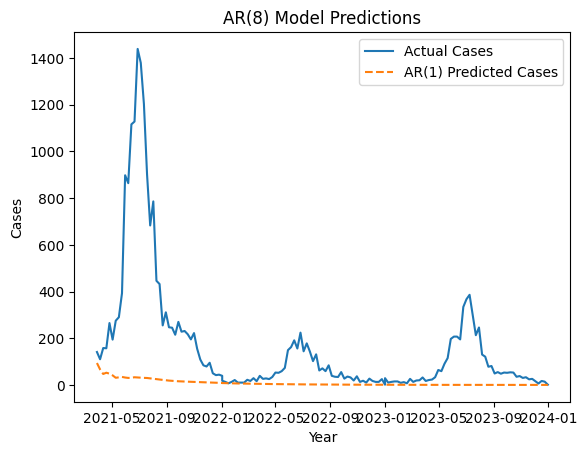

In [19]:
plt.plot(test_data['Cases'], label = 'Actual Cases')
plt.plot(pred_data2['pred Cases'], label = 'AR(1) Predicted Cases', linestyle = '--')
plt.xlabel('Year')
plt.ylabel('Cases')
plt.legend()
plt.title('AR(8) Model Predictions')
plt.show();

In [59]:
X_train = np.array(train_data['Lag 2']).reshape(-1,1)

print(X_train.shape)
print(y_train.shape)

(30, 1)
(30, 1)


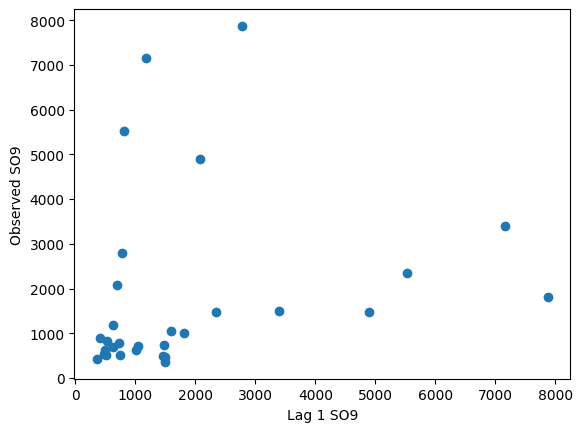

In [60]:
plt.scatter(x = X_train, y = y_train)
plt.xlabel('Lag 1 SO9')
plt.ylabel('Observed SO9')
plt.show();

In [61]:
w = np.dot(np.linalg.inv(np.dot(X_train.T, X_train)), np.dot(X_train.T, y_train))
w

array([[0.58097629]])

In [62]:
y_pred = []
start = X_train[len(X_train)-1].reshape(-1,1)
for i in range(len(y_test)):
    y_pred.append(w.T.dot(start).flatten()[0])
    start = y_pred[i].reshape(-1,1)

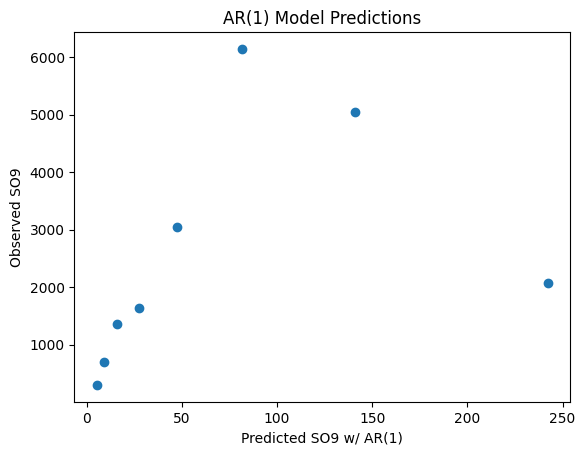

In [63]:
plt.scatter(x = y_pred, y = y_test)
plt.xlabel('Predicted SO9 w/ AR(1)')
plt.ylabel('Observed SO9')
plt.title('AR(1) Model Predictions')
plt.show();

In [64]:
pred_data = pd.DataFrame({'Date': test_data.index, 'pred COUNT': y_pred})
pred_data.set_index('Date', inplace = True)
pred_data.head()

,pred COUNT
Date,
2019-05-01,242.267111
2019-06-01,140.751446
2019-07-01,81.773252
2019-08-01,47.508320
2019-09-01,27.601208


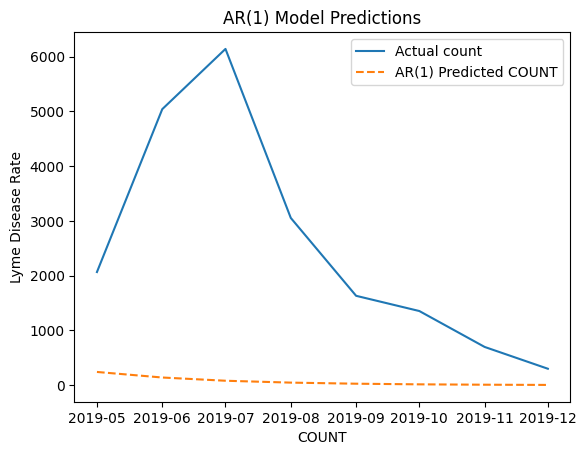

In [65]:
plt.plot(test_data['COUNT'], label = 'Actual count')
plt.plot(pred_data['pred COUNT'], label = 'AR(1) Predicted COUNT', linestyle = '--')
plt.xlabel('COUNT')
plt.ylabel('Lyme Disease Rate')
plt.legend()
plt.title('AR(1) Model Predictions')
plt.show();

In [20]:
from statsmodels.tsa.arima.model import ARIMA

In [21]:
train_size = int(.8 * len(lyme_disease_rate))
train_data = lyme_disease_rate[:train_size]
test_data = lyme_disease_rate[train_size:]

# put the y feature (the current SO9) in arrays
y_train = np.array(train_data['Cases']).reshape(-1,1)
y_test = np.array(test_data['Cases']).reshape(-1,1)

In [22]:
print(test_data.columns)

Index(['Cases', 'Lag 1', 'Lag 2', 'Lag 3', 'Lag 4', 'Lag 5', 'Lag 6', 'Lag 7',
       'Lag 8', 'Lag 9', 'Lag 10'],
      dtype='object')


In [23]:
ma_model = ARIMA(y_train, order=(0, 0, 20))
ma_results = ma_model.fit()
ma_results.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  585
Model:                ARIMA(0, 0, 20)   Log Likelihood               -3749.395
Date:                Wed, 09 Apr 2025   AIC                           7542.790
Time:                        14:01:27   BIC                           7638.966
Sample:                             0   HQIC                          7580.272
                                - 585                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        444.7689    111.399      3.993      0.000     226.432     663.106
ma.L1          0.8134      0.037     22.122      0.000       0.741       0.885
ma.L2          1.2054      0.048     24.922      0.000       1.111       1.300
ma.L3          1.2517      0.070     17.826      0.000       1.114       1.389
ma.L4          1.5705      0.085     18.514      0.000       1.404       1.737
ma.L5          1.4356      0.101     14.245      0.000       1.238       1.633
ma.L6          1.2678      0.110     11.566      0.000       1.053       1.483
ma.L7          0.9565      0.116      8.225      0.000       0.729       1.184
ma.L8          0.8146      0.122      6.683      0.000       0.576       1.054
ma.L9          0.7038      0.137      5.147      0.000       0.436       0.972
ma.L10         0.4490      0.146      3.069      0.002       0.162       0.736
ma.L11         0.3361      0.157      2.142      0.032       0.029       0.644
ma.L12         0.1415      0.161      0.880      0.379      -0.174       0.457
ma.L13         0.3590      0.163      2.204      0.028       0.040       0.678
ma.L14         0.1008      0.162      0.621      0.534      -0.217       0.419
ma.L15         0.1624      0.159      1.021      0.307      -0.149       0.474
ma.L16         0.1112      0.145      0.769      0.442      -0.172       0.395
ma.L17         0.1981      0.124      1.600      0.110      -0.045       0.441
ma.L18         0.0367      0.097      0.378      0.706      -0.154       0.227
ma.L19        -0.1187      0.069     -1.720      0.085      -0.254       0.017
ma.L20        -0.1306      0.058     -2.270      0.023      -0.243      -0.018
sigma2      2.134e+04   1090.491     19.565      0.000    1.92e+04    2.35e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              1034.27
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             1.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
ma_pred = ma_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data = pd.DataFrame({'Date': test_data.index, 'pred Cases': ma_pred.flatten()})
pred_data.set_index('Date', inplace = True)
pred_data.head()

,pred Cases
Date,
2021-03-28,63.891187
2021-04-04,80.989159
2021-04-11,135.752312
2021-04-18,223.067277
2021-04-25,309.652011


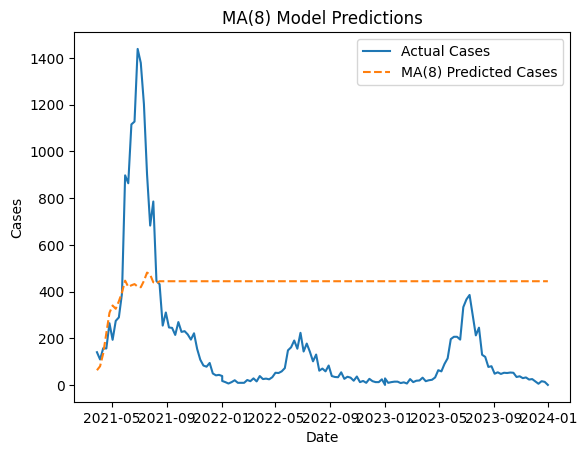

In [25]:
plt.plot(test_data['Cases'], label = 'Actual Cases')
plt.plot(pred_data['pred Cases'], label = 'MA(8) Predicted Cases', linestyle = '--')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.title('MA(8) Model Predictions')
plt.show();

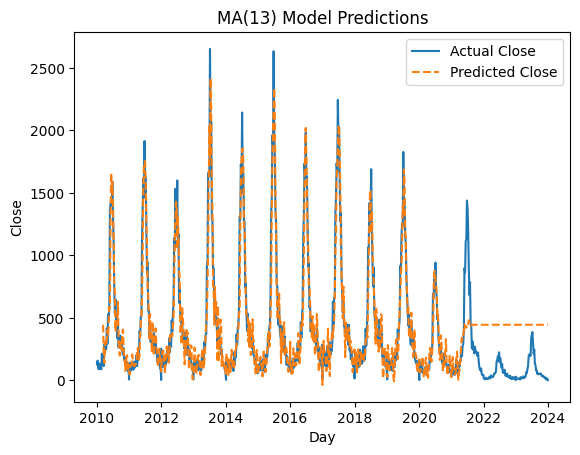

In [26]:
ma_pred_full = ma_results.predict(start=0, end=len(train_data) + len(test_data) - 1) # note we start at zero

plt.plot(lyme_diease_rate['Cases'], label = 'Actual Close')
plt.plot(lyme_disease_rate.index, ma_pred_full, label = 'Predicted Close', linestyle = '--')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.title('MA(13) Model Predictions')
plt.show();

In [27]:
arma_model = ARIMA(y_train, order=(5, 0, 5)) # here is the MA(1) model
arma_results = arma_model.fit()
arma_results.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  585
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -3728.514
Date:                Wed, 09 Apr 2025   AIC                           7481.029
Time:                        14:01:58   BIC                           7533.488
Sample:                             0   HQIC                          7501.473
                                - 585                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        444.7901    103.431      4.300      0.000     242.068     647.512
ar.L1          1.1278      0.158      7.144      0.000       0.818       1.437
ar.L2         -0.6167      0.218     -2.833      0.005      -1.043      -0.190
ar.L3          0.2377      0.189      1.258      0.208      -0.133       0.608
ar.L4          0.4736      0.163      2.898      0.004       0.153       0.794
ar.L5         -0.4168      0.075     -5.544      0.000      -0.564      -0.269
ma.L1         -0.4374      0.161     -2.715      0.007      -0.753      -0.122
ma.L2          1.0458      0.123      8.528      0.000       0.805       1.286
ma.L3         -0.0229      0.221     -0.104      0.918      -0.457       0.411
ma.L4          0.2256      0.111      2.030      0.042       0.008       0.443
ma.L5          0.2526      0.122      2.070      0.038       0.013       0.492
sigma2      2.041e+04    847.669     24.082      0.000    1.88e+04    2.21e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1513.11
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                             1.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
abs(arma_results.maroots)

array([1.18902718, 1.18902718, 1.13685169, 1.13685169, 2.16684707])

In [29]:
arma_pred = arma_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data = pd.DataFrame({'Date': test_data.index, 'pred Cases': arma_pred.flatten()})
pred_data.set_index('Date', inplace = True)
pred_data.head()

,pred Cases
Date,
2021-03-28,108.780004
2021-04-04,118.896095
2021-04-11,133.066062
2021-04-18,158.085026
2021-04-25,226.708703


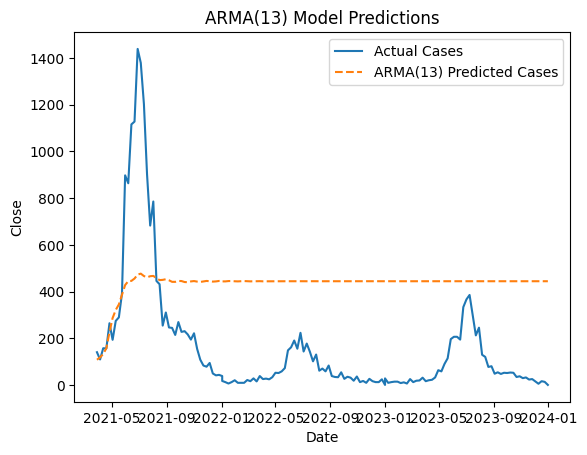

In [30]:
plt.plot(test_data['Cases'], label = 'Actual Cases')
plt.plot(pred_data['pred Cases'], label = 'ARMA(13) Predicted Cases', linestyle = '--')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.title('ARMA(13) Model Predictions')
plt.show();

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(y_train, 
                 order=(6, 1, 6),  # Non-seasonal: AR(7), differencing (1), MA(7)
                 seasonal_order=(7, 0, 1, 7))
results = sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.38251D+00    |proj g|=  3.00632D-01


 This problem is unconstrained.



At iterate    5    f=  6.34916D+00    |proj g|=  2.23523D-02

At iterate   10    f=  6.34245D+00    |proj g|=  2.75197D-02

At iterate   15    f=  6.33904D+00    |proj g|=  1.73782D-02

At iterate   20    f=  6.33579D+00    |proj g|=  3.28401D-02

At iterate   25    f=  6.32887D+00    |proj g|=  2.62850D-02

At iterate   30    f=  6.32302D+00    |proj g|=  2.39336D-02

At iterate   35    f=  6.32184D+00    |proj g|=  1.05098D-02

At iterate   40    f=  6.32010D+00    |proj g|=  1.01942D-02

At iterate   45    f=  6.31953D+00    |proj g|=  2.59205D-03


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.31937D+00    |proj g|=  2.48063D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     56      1     0     0   2.481D-03   6.319D+00
  F =   6.3193745259274650     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


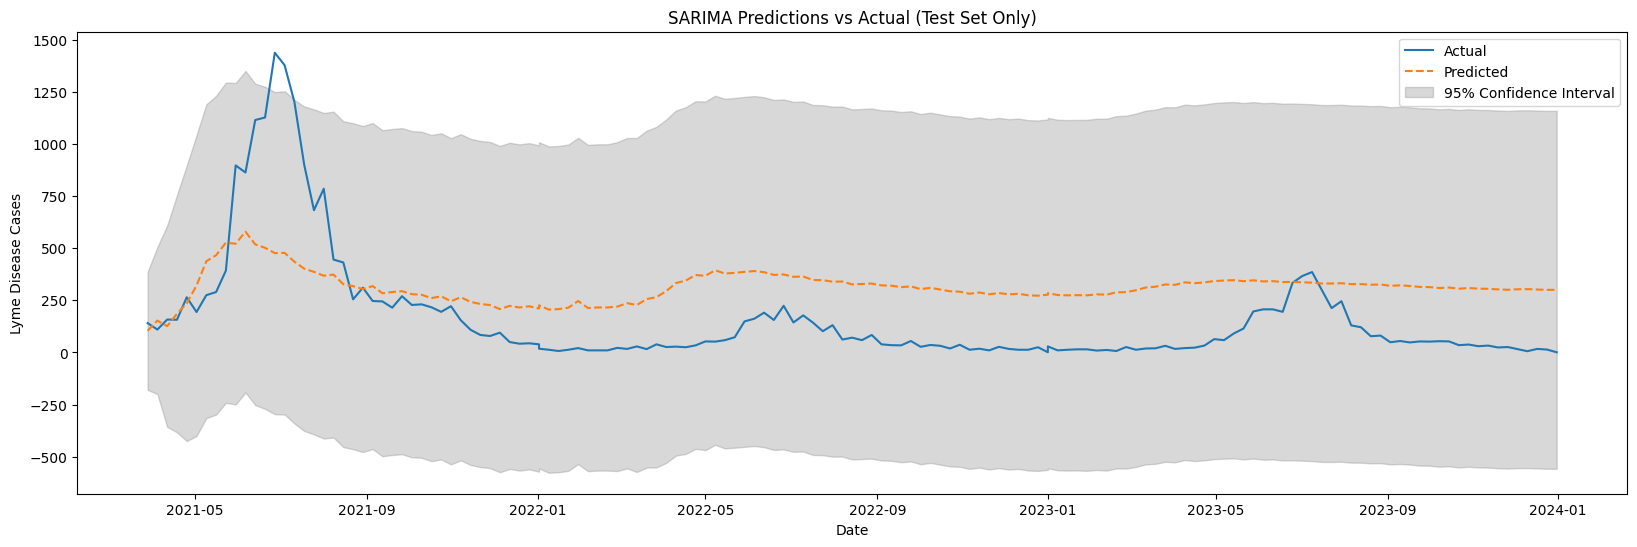

In [32]:
predicted = results.get_forecast(steps=len(y_test))
predicted_values = predicted.predicted_mean

conf_int = predicted.conf_int()

# Plot actual test data vs predicted
plt.figure(figsize=(20, 6))

# Plot actual test data
plt.plot(test_data.index, test_data['Cases'], label='Actual')  # Corrected to use 'Cases' not 'meantemp'

# Plot predictions
plt.plot(test_data.index, predicted_values, label='Predicted', linestyle='--')

plt.fill_between(test_data.index, 
                 conf_int[:, 0],  # Lower bound of confidence interval
                 conf_int[:, 1],  # Upper bound of confidence interval
                 color='gray', alpha=0.3, label='95% Confidence Interval')

plt.legend()
plt.title("SARIMA Predictions vs Actual (Test Set Only)")
plt.xlabel("Date")
plt.ylabel("Lyme Disease Cases")
plt.show()